In [532]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [79]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories']

In [83]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo


In [84]:
repos = get_repos(g_url)

In [91]:
repos

['/jtleek/datasharing',
 '/rdpeng/ProgrammingAssignment2',
 '/octocat/Spoon-Knife',
 '/tensorflow/tensorflow',
 '/SmartThingsCommunity/SmartThingsPublic',
 '/twbs/bootstrap',
 '/github/gitignore',
 '/rdpeng/ExData_Plotting1',
 '/tensorflow/models',
 '/nightscout/cgm-remote-monitor',
 '/facebook/react',
 '/DataScienceSpecialization/courses',
 '/angular/angular.js',
 '/jlord/patchwork',
 '/barryclark/jekyll-now',
 '/Snailclimb/JavaGuide',
 '/firstcontributions/first-contributions',
 '/bitcoin/bitcoin',
 '/spring-projects/spring-framework',
 '/vuejs/vue',
 '/getify/You-Dont-Know-JS',
 '/freeCodeCamp/freeCodeCamp',
 '/kubernetes/kubernetes',
 '/udacity/frontend-nanodegree-resume',
 '/mrdoob/three.js',
 '/TheAlgorithms/Python',
 '/LarryMad/recipes',
 '/ant-design/ant-design',
 '/d3/d3',
 '/apache/spark',
 '/DefinitelyTyped/DefinitelyTyped',
 '/django/django',
 '/apache/dubbo',
 '/996icu/996.ICU',
 '/justjavac/free-programming-books-zh_CN',
 '/ohmyzsh/ohmyzsh',
 '/scikit-learn/scikit-learn',

In [92]:
#repos = scraper.get_repos(g_url)

/Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py:28: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 28 of the file /Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [481]:
f = open('data.json')
json_file = json.load(f)

In [515]:
df = pd.DataFrame(json_file)

In [516]:
df

,repo,language,readme_contents
0,jenkins-docs/simple-java-maven-app,Java,# simple-java-maven-app\n\nThis repository is ...
1,Trinea/android-open-project,None,Android 开源项目分类汇总，更全更新可见 [codekk.com](https://p...
2,trekhleb/javascript-algorithms,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...
3,udacity/fullstack-nanodegree-vm,Python,# Full Stack Web Developer Nanodegree program ...
4,scutan90/DeepLearning-500-questions,None,# 禁止转载，禁止转载，禁止转载！\n# GitHub上非最新内容，最新内容请期待新书。\n...
...,...,...,...
105,pjreddie/darknet,C,![Darknet Logo](http://pjreddie.com/media/file...
106,odoo/odoo,JavaScript,[![Build Status](http://runbot.odoo.com/runbot...
107,doocs/advanced-java,Java,# 互联网 Java 工程师进阶知识完全扫盲<sup>[©](https://github....
108,Homebrew/legacy-homebrew,None,# Homebrew (Legacy)\n\nThis repository was dep...


In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             110 non-null    object
 1   language         96 non-null     object
 2   readme_contents  110 non-null    object
dtypes: object(3)
memory usage: 2.7+ KB


In [518]:
df.isnull().sum()

repo                0
language           14
readme_contents     0
dtype: int64

In [519]:
df = df.dropna(axis =0)

In [520]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 109
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             96 non-null     object
 1   language         96 non-null     object
 2   readme_contents  96 non-null     object
dtypes: object(3)
memory usage: 3.0+ KB


In [521]:
df = df.reset_index(drop = True)

In [522]:
df.language.value_counts()

JavaScript          25
Python              14
Java                 9
TypeScript           6
CSS                  5
HTML                 5
C++                  5
Go                   4
C                    4
Jupyter Notebook     3
Shell                2
C#                   2
PHP                  2
Vue                  2
Scala                1
Groovy               1
Rust                 1
Dart                 1
ApacheConf           1
R                    1
Kotlin               1
Ruby                 1
Name: language, dtype: int64

In [523]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Scala','Rust','C#','Dart','Ruby'], 'Other')

In [524]:
df.language.value_counts()

JavaScript    25
Other         19
Python        14
Java           9
TypeScript     6
C++            5
HTML           5
CSS            5
Go             4
C              4
Name: language, dtype: int64

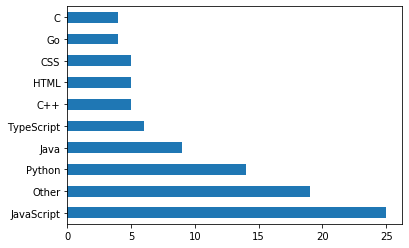

In [525]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [526]:
df = df.drop(columns = ['repo'])

In [531]:
df.head(4)

,language,readme_contents
0,Java,# simple-java-maven-app\n\nThis repository is ...
1,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...
2,Python,# Full Stack Web Developer Nanodegree program ...
3,Other,![seclists.png](https://danielmiessler.com/ima...


In [538]:
y = df.language
X = df.readme_contents
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

In [542]:
train

,language,readme_contents
81,JavaScript,# Introduction\n\n[![npm version](https://img....
2,Python,# Full Stack Web Developer Nanodegree program ...
92,C,![Darknet Logo](http://pjreddie.com/media/file...
58,Java,<!-- the line below needs to be an empty line ...
39,TypeScript,"<p align=""center"">\n <a href=""https://ant.des..."
...,...,...
83,JavaScript,"# ECharts\n\n<a href=""https://echarts.apache.o..."
95,Other,# the-craft-of-selfteaching\n\n> One has no fu...
51,C,[![Build status](https://github.com/git/git/wo...
30,Java,> JavaGuide 的Star数量虽然比较多，但是它的价值和含金量一定是不能和 Dubb...


In [543]:
train1 = train.readme_contents.groupby(train.language).sum()

In [544]:
train1 = pd.DataFrame(train1).reset_index()

In [545]:
train1.head(4)

,language,readme_contents
0,C,![Darknet Logo](http://pjreddie.com/media/file...
1,C++,Bitcoin Core integration/staging tree\n=======...
2,CSS,# [Minimal Mistakes Jekyll theme](https://mmis...
3,Go,## 蓝灯(Lantern)最新版本下载 版本![](https://bitbucket.o...


In [546]:
train = prepare_r.prep_contents(train)

In [548]:
train = train.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
train.head(4)

,language,readme_contents,cleaned
81,JavaScript,# Introduction\n\n[![npm version](https://img....,introduction npm version img shield npm admin ...
2,Python,# Full Stack Web Developer Nanodegree program ...,full stack web developer nanodegree program vi...
92,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...
58,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...


In [549]:
train1 = prepare_r.prep_contents(train1)

In [550]:
train1 = train1.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])


In [551]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com           3305
org            903
python         829
javascript     592
doc            564
name           554
learning       519
library        504
data           500
machine        412
html           404
code           392
use            377
example        367
function       357
dtype: int64

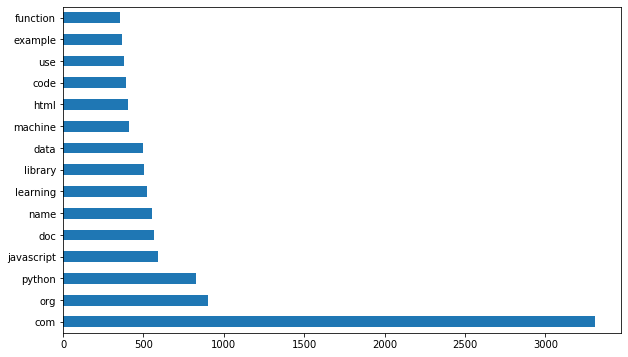

In [552]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [553]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in df.cleaned if word in doc])
    return len(df.cleaned) / n_occurences

In [554]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['introduction', 'npm', 'version', ..., 'gcr', 'quay',
       'cloudnativeapp'], dtype=object)

In [560]:
train.cleaned

81    introduction npm version img shield npm admin ...
2     full stack web developer nanodegree program vi...
92    darknet logo pjreddie com medium file darknet ...
58    line need empty line kramdown isnt smart dearl...
39    align center href ant design img width src ali...
                            ...                        
83    echarts href echarts apache org img style vert...
95    craft selfteaching one ha future one teach the...
51    build status com git git workflow badge svg co...
30    javaguide star dubbonacos java javaguide doc j...
79    helm chart canonical source helm chart helm hu...
Name: cleaned, Length: 76, dtype: object

In [563]:
# put the unique words into a data frame
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

AttributeError: 'DataFrame' object has no attribute 'cleaned'

In [507]:
idf_df.head(10)

,idf
word,
oxforddictionaries,96.0
propertygraph,96.0
terminology,96.0
whitelisting,96.0
baqend,96.0
wskogqenq,96.0
wxgqg,96.0
infoq,96.0
jekylls,96.0


Text(0.5, 0, 'IDF value')

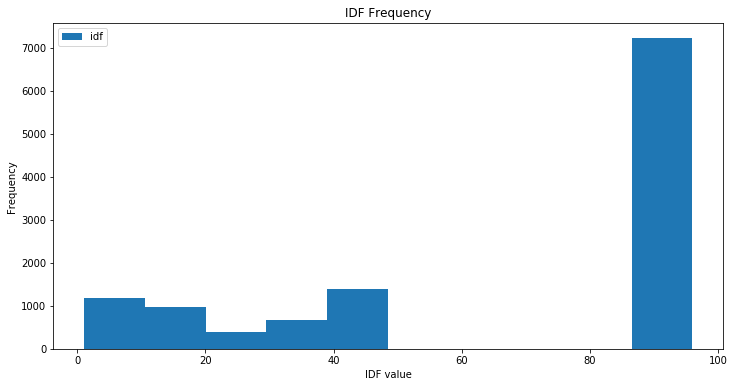

In [508]:
idf_df.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [509]:
df

,language,readme_contents,cleaned
0,Java,# simple-java-maven-app\n\nThis repository is ...,simple java maven app repository build java ap...
1,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...,algoritmos estructuras datos javascript build ...
2,Python,# Full Stack Web Developer Nanodegree program ...,full stack web developer nanodegree program vi...
3,Other,![seclists.png](https://danielmiessler.com/ima...,seclists png danielmiessler com image seclists...
4,Python,[![Build Status](https://travis-ci.org/ytdl-or...,build status travis org ytdl org youtube svg b...
...,...,...,...
91,Other,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,flutter logo flutter dev build status cirrus b...
92,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...
93,JavaScript,[![Build Status](http://runbot.odoo.com/runbot...,build status runbot odoo com runbot badge flat...
94,Java,# 互联网 Java 工程师进阶知识完全扫盲<sup>[©](https://github....,java sup com yanglbme sup action status com do...


In [510]:
# here we create a new column with number of words for each readme file.
df['readme_words'] = df['cleaned'].apply(lambda x: len(x.split()))

In [511]:
df.head(4)

,language,readme_contents,cleaned,readme_words
0,Java,# simple-java-maven-app\n\nThis repository is ...,simple java maven app repository build java ap...,66
1,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...,algoritmos estructuras datos javascript build ...,2017
2,Python,# Full Stack Web Developer Nanodegree program ...,full stack web developer nanodegree program vi...,815
3,Other,![seclists.png](https://danielmiessler.com/ima...,seclists png danielmiessler com image seclists...,182


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

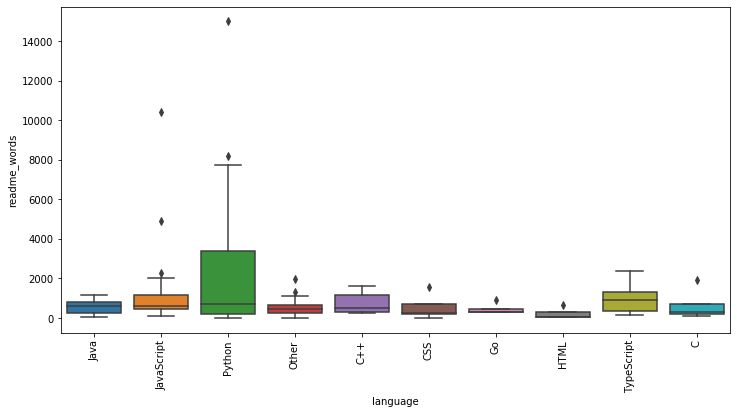

In [512]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = df)
plt.xticks(rotation = 90)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [428]:
df1

,language,readme_contents,cleaned
0,C,[![Build status](https://github.com/git/git/wo...,build status com git git workflow badge svg co...
1,C#,# ASP.NET Core Docs\n\nThis repository contain...,asp net core doc repository contains conceptua...
2,C++,"<div align=""center"">\n <img src=""https://www....",div align center img src tensorflow org image ...
3,CSS,"> March, 2016: If you're on an old version of ...",march old version jekyll run build warning syn...
4,Dart,# [![Flutter logo][]][flutter.dev]\n\n[![Build...,flutter logo flutter dev build status cirrus b...
5,Go,# Kubernetes\n\n[![GoDoc Widget]][GoDoc] [![CI...,kubernetes godoc widget godoc cii best practic...
6,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public repo official list smartapp...
7,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...
8,Java,> JavaGuide 的Star数量虽然比较多，但是它的价值和含金量一定是不能和 Dubb...,javaguide star dubbonacos java javaguide doc j...
9,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...


In [ ]:
def words_():
    